## 问题概述
问题说明：你将获得一个包含以下内容的数据集（"data.h5"）：

     标记为cat（y = 1）或非cat（y = 0）的m_train训练图像集
     标记为cat或non-cat的m_test测试图像集
     图像维度为（num_px，num_px，3），其中3表示3个通道（RGB）。 因此，每个图像都是正方形（高度= num_px）和（宽度= num_px）。
你将构建一个简单的图像识别算法，该算法可以将图片正确分类为猫和非猫。


In [2]:
# 让我们熟悉一下数据集吧， 首先通过运行以下代码来加载数据

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset


In [4]:

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


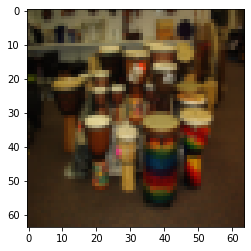

In [5]:
# Example of a picture
index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
#print("train_set_x_orig 5 ="+str(train_set_x_orig[5]))

## 练习：
查找以下各项值
* m_train(训练集示例数量)
* m_test(测试集示例数量)
* num_px(=训练图像的高度=训练图像的宽度)
请记住：train_set_x_orig是一个纬度为（m_train,num_px,num_px,3）的numpy数组

In [6]:
print(train_set_x_orig.shape)

(209, 64, 64, 3)


In [7]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print("m_train:"+str(m_train))
print("m_test:"+str(m_test))
print("num_px:"+str(num_px))
print("标签纬度："+str(test_set_y.shape)) #1行 20列

m_train:209
m_test:50
num_px:64
标签纬度：(1, 50)


In [8]:
print(str(test_set_y))

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


## 练习
重塑训练和测试数据集，以便将大小（num_px, num_px, 3）的图像展平为单个形状的向量（num_px*num_px*3,1）

当你想将维度为（a，b，c，d）的矩阵X展平为形状为(bcd, a)的矩阵X_flatten时的一个技巧是：

X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵
**而不用显式地去构建纬度，算是一种语法糖吧**

In [9]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print("train_set_x_flatten shape:"+str(train_set_x_flatten.shape))
print("test_set_x_flatten shape:"+str(test_set_x_flatten.shape))

train_set_x_flatten shape:(12288, 209)
test_set_x_flatten shape:(12288, 50)


# 标准化数据
为了表示彩色图像，必须为每个像素指定红、绿、蓝色通道（RGB），因此像素值实际上是一个从0到255的三个数字的向量。

机器学习中一个常见的预处理步骤是**对数据集进行居中和标准化**，这意味着你要从每个示例中减去整个numpy数组的均值，然后除以整个numpy数组的标准差。但是图片数据集则更为简单方便，并且只要将数据集的每一行除以255（像素通道的最大值），效果也差不多。

在训练模型期间，你将要乘以权重并向一些初始输入添加偏差以观察神经元的激活。然后，使用反向梯度传播以训练模型。但是，让特征具有相似的范围以至渐变不会爆炸是非常重要的。具体内容我们将在后面的教程中详细学习！

开始标准化我们的数据集吧！

In [10]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255


**你需要记住的内容：**
预处理数据集的常见步骤是：

* 找出数据的尺寸和维度（m_train，m_test，num_px等）
* 重塑数据集，以使每个示例都是大小为（num_px \ num_px \ 3，1）的向量
* “标准化”数据

# 学习算法的一般架构
现在是时候设计一种简单的算法来区分猫图像和非猫图像了。

你将使用神经网络思维方式建立Logistic回归。 下图说明了为什么“逻辑回归实际上是一个非常简单的神经网络！”


**算法的数学表达式**
//需进行推导

**算法的关键步骤**
* 初始化模型参数
* 通过最小化损失来学习模型的参数
* 使用学习到的参数进行预测（在测试集上）
* 分析结果并得出结论

# 构建算法的各个部分
建立神经网络的主要步骤：
1. 定义模型结构
2. 初始化模型参数
3. 循环 ：
* 计算当前损失（正向传播）
* 计算当前梯度 （向后传播）
* 更新参数（梯度下降）

你通常会分别构建1-3，然后将它们集成到一个称为“model()”的函数中

**4.1-辅助函数**
**练习：** 使用Python实现sigmoid（）。需要计算sigmoid去预测。使用np.exp()

In [11]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

# 测试

z = 123
s = sigmoid(z)
print("z:"+str(s))

z:1.0


In [12]:
z = np.array([0,2])
print("z的形状 {} z:{}".format(z.shape,z))
s = sigmoid(z)
print("s的形状 {} s:{}".format(s.shape,s))

z的形状 (2,) z:[0 2]
s的形状 (2,) s:[0.5        0.88079708]


**4.2-初始化参数**
**练习：** 在下面的单元格中实现参数初始化。你必须将w初始化为零向量。

In [13]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b, float) or isinstance(b,int))
    
    return w,b

In [14]:
dim = 2
#w shape (dim,1) 的矩阵（列向量） 代表有dim个纬度的特征的权重
#b 0 
w, b = initialize_with_zeros(dim)
print("w {}".format(w))
print("b {}".format(b))

#对于图像输入，w的纬度为(num_px * num_px * 3,1)

w [[0.]
 [0.]]
b 0


**4.3- 前向和后向传播**
现在，你的参数已经初始化，你可以执行“向前”和“向后”传播步骤来学习参数。
**练习：**
实现函数propagate()来计算损失函数及其梯度。
**提示：**
正向传播：
* 默认都是列向量


In [15]:
def propagate(w, b, X, Y):
    # 样本个数
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    #MEMO 这里的矩阵的乘法*使用了广播吗 区别于dot
    cost = -1/m * np.sum(Y * np.log(A) + ( 1- Y) * np.log(1 - A))
    
    #MEMO 这里的矩阵的减-使用了广播吗
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw":dw,"db":db}
    
    return grads, cost
    

In [18]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2,3],[3,4,5]]), np.array([[1,0,0]])
print("w {} 列向量".format(w.shape))
# print("b {}".format(b.shape))
print("X {} 列向量".format(X.shape))
print("Y {} 行向量".format(Y.shape))
print("符合 w.T*X的运算规则")


grads, cost = propagate(w, b, X, Y)
print ("dw = {} {}".format(str(grads["dw"]),grads["dw"].shape))
print ("db = {} {}".format(str(grads["db"]),grads["db"].shape))
print ("cost = " + str(cost))

w (2, 1) 列向量
X (2, 3) 列向量
Y (1, 3) 行向量
符合 w.T*X的运算规则
dw = [[1.66662113]
 [2.9998679 ]] (2, 1)
db = 0.6666233851157282 ()
cost = 9.000043284021533


In [17]:
s = np.array([1,2,3])
s1 = np.array([4,5,6])
print("广播 s*s1:{} s1*s:{}".format(s*s1,s1*s))

广播 s*s1:[ 4 10 18] s1*s:[ 4 10 18]


**优化函数**
* 初始化参数
* 计算损失函数及其梯度
* 依据梯度下降来更新参数

In [57]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    
    costs = []
    
   
    
 
    #assert(dw.shape == w.shape)
    #assert(isinstance(b, int))
    #assert( float == db.dtype)

    
    for i in range(0,num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
    
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
            
    if print_cost:
        print("************")
        print("{} times".format(num_iterations))
        print("w: {}".format(w))
        print("b: {}".format(b))
        print("costs:{}".format(costs))

    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs
    
    

In [58]:
#Test 100次
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2,3],[3,4,5]]), np.array([[1,0,0]])
for i in range(100,300,100):
    optimize(w, b, X, Y, i, 0.01, True)


************
100 times
w: [[-0.32790317]
 [-0.34238201]]
b: 1.4927605814216813
costs:[9.000043284021533]
************
200 times
w: [[-0.47937796]
 [-0.4188208 ]]
b: 1.5302785776280574
costs:[9.000043284021533, 0.4503949890210387]


**练习**： 上一个函数将输出学习到的w和b。 我们能够使用w和b来预测数据集X的标签。实现predict（）函数。 预测分类有两个步骤：
1.计算 a
2.将a的项转换为0（如果激活<= 0.5）或1（如果激活> 0.5），并将预测结果存储在向量“ Y_prediction”中。 如果愿意，可以在for循环中使用if / else语句。

In [59]:
def predict(w, b, X):
    """
    w 在训练数据集上学习的权重矩阵
    b 在训练数据集上学习的参数常量
    X 待预测的数据集
    """
    # 样本个数
    m = X.shape[1]
    # 预测值（注意矩阵的shape）
    Y_prediction = np.zeros((1,m))
    # 权重矩阵<=纬度=>特征的个数
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    assert(Y_prediction.shape == A.shape)
    
    for i in range(A.shape[1]):
        
        if A[0,i]>0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    assert(Y_prediction.shape == (1,m))   
    
    return Y_prediction

In [60]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)
print ("predictions = " + str(predict(params["w"], params["b"], X)))

predictions = [[1. 1.]]


In [61]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
     # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
     # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [62]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

************
2000 times
w: [[ 0.00961402]
 [-0.0264683 ]
 [-0.01226513]
 ...
 [-0.01144453]
 [-0.02944783]
 [ 0.02378106]]
b: -0.015906243999692978
costs:[0.6931471805599453, 0.5845083636993087, 0.4669490409465547, 0.37600686694802077, 0.3314632893282512, 0.30327306747438293, 0.27987958658260487, 0.2600421369258757, 0.2429406846779662, 0.2280042225672606, 0.2148195137844964, 0.20307819060644988, 0.19254427716706862, 0.18303333796883503, 0.17439859438448874, 0.16652139705400326, 0.15930451829756614, 0.15266732471296504, 0.1465422350398234, 0.1408720757031016]
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**评价**：训练准确性接近100％。 这是一个很好的情况：你的模型正在运行，并且具有足够的容量来适合训练数据。 测试误差为68％。 考虑到我们使用的数据集很小，并且逻辑回归是线性分类器，对于这个简单的模型来说，这实际上还不错。 但请放心，下周你将建立一个更好的分类器！

此外，你会看到该模型明显适合训练数据。 在本专业的稍后部分，你将学习如何减少过度拟合，例如通过使用正则化。 使用下面的代码（并更改index变量），你可以查看测试集图片上的预测。

y = 1, you predicted that it is a "cat" picture.


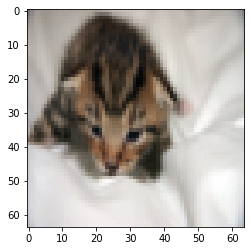

In [63]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")


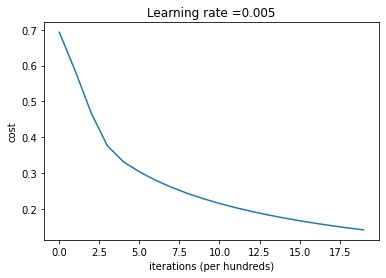

In [64]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**解释：**
损失下降表明正在学习参数。 但是，你看到可以在训练集上训练更多模型。 尝试增加上面单元格中的迭代次数，然后重新运行这些单元格。 你可能会看到**训练集准确性提高了，但是测试集准确性却降低了**。 这称为**过度拟合**。

**学习率的选择**
提醒：
为了使梯度下降起作用，你必须明智地选择学习率。 学习率决定我们更新参数的速度。 如果**学习率太大**，我们可能会“超出”最佳值。 同样，如果**太小**，将需要更多的迭代才能收敛到最佳值。 这也是为什么调整好学习率至关重要。

让我们将模型的学习曲线与选择的几种学习率进行比较。 运行下面的单元格。 这大约需要1分钟。 还可以尝试与我们初始化要包含的“ learning_rates”变量的三个值不同的值，然后看看会发生什么。

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



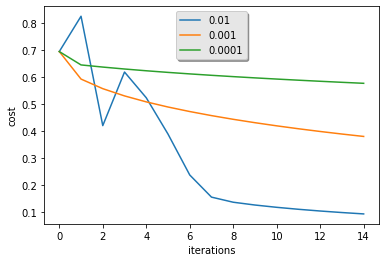

In [65]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**解释：**
不同的学习率会带来不同的损失，因此会有不同的预测结果。
如果学习率太大（0.01），则成本可能会上下波动。 它甚至可能会发散（尽管在此示例中，使用0.01最终仍会以较高的损失值获得收益）。
较低的损失并不意味着模型效果很好。当训练精度比测试精度高很多时，就会发生过拟合情况。
在深度学习中，我们通常建议你：
     选择好能最小化损失函数的学习率。
     **如果模型过度拟合，请使用其他方法来减少过度拟合**。 （我们将在后面的教程中讨论。）


# 此作业要记住的内容：

**预处理数据集很重要。**
如何实现每个函数：initialize（），propagation（），optimize（），并用此构建一个model（）。
调整学习速率（这是“超参数”的一个示例）可以对算法产生很大的影响。 你将在本课程的稍后部分看到更多示例！
最后，如果你愿意，我们邀请你在此笔记本上尝试其他操作。 在尝试任何操作之前，请确保你正确提交。 提交后，你可以学习了解的包括：

* 发挥学习率和迭代次数
* 尝试不同的初始化方法并比较结果
* 测试其他预处理（将数据居中，或将每行除以其标准偏差）
